<a href="https://colab.research.google.com/github/PhChLong/ML-DL/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.v2 import ToTensor
from torchvision import datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [35]:
transform_train = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomCrop(32, padding=4),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomRotation(15),
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
transform_test = v2.Compose([
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
trainset = datasets.CIFAR100(root = './data', train = True, download= True, transform = transform_train)
testset = datasets.CIFAR100(root = './data', train = False, download= True, transform = transform_test)

train_size = int(0.8* len(trainset))
valid_size = len(trainset) - train_size
trainset, validset = random_split(trainset, [train_size, valid_size])

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = False)
test_loader = DataLoader(testset, batch_size = 64, shuffle = False)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [36]:
def train_dataloader_model(
    model, train_loader, valid_loader, optim, loss_fn,
    device=None, max_epochs=100, diff=1e-3, patience=5
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    valid_loss_min = float("inf")
    patience_counter = 0

    for epoch in range(max_epochs):
        # ----------------------------
        # TRAINING PHASE
        # ----------------------------
        model.train()
        running_train_loss = 0.0

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optim.zero_grad()
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optim.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # ----------------------------
        # VALIDATION PHASE
        # ----------------------------
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_pred = model(X_valid)

                # Compute validation loss
                loss = loss_fn(y_pred, y_valid)
                running_valid_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(y_pred, 1)
                correct += (predicted == y_valid).sum().item()
                total += y_valid.size(0)

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        epoch_valid_acc = correct / total

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        scheduler.step(epoch_valid_loss)
        # ----------------------------
        # EARLY STOPPING CHECKS
        # ----------------------------
        if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < diff:
            print(f"epoch {epoch}: loss diff < {diff} → early convergence.")
            break

        if epoch_valid_loss < valid_loss_min - diff:
            valid_loss_min = epoch_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        print(
            f"Epoch [{epoch+1}/{max_epochs}] | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Valid Loss: {epoch_valid_loss:.4f} | "
            f"Valid Acc: {epoch_valid_acc*100:.2f}%"
        )

        if patience_counter >= patience:
            print(f"\nEarly stopping: no improvement for {patience} epochs.")
            break

    # ----------------------------
    # PLOTTING BEFORE RETURN
    # ----------------------------
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, label="Valid Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, valid_losses, valid_accuracies


In [37]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.relu(Y)

In [38]:
class ResNet(nn.Module):
    def block(self, num_residuals, in_channel, out_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channel, out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
            in_channel = out_channels
        return nn.Sequential(*blk)

    def __init__(self, arch, num_classes=100):
        super(ResNet, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.net = nn.Sequential(self.b1)
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(512, num_classes)))
    def forward(self, x):
        return self.net(x)

In [39]:
class ResNet18(ResNet):
    def __init__(self, num_classes=100):
        super().__init__(((2, 64, 64), (2, 64, 128), (2, 128, 256), (2, 256, 512))
                         , num_classes)

In [40]:
model = ResNet18().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=3)

Epoch [1/100] | Train Loss: 4.0131 | Valid Loss: 3.7340 | Valid Acc: 11.13%
Epoch [2/100] | Train Loss: 3.4968 | Valid Loss: 3.3389 | Valid Acc: 18.83%
Epoch [3/100] | Train Loss: 3.2039 | Valid Loss: 3.2196 | Valid Acc: 21.31%
Epoch [4/100] | Train Loss: 2.9825 | Valid Loss: 2.9885 | Valid Acc: 25.31%
Epoch [5/100] | Train Loss: 2.7995 | Valid Loss: 2.7639 | Valid Acc: 29.45%
Epoch [6/100] | Train Loss: 2.6331 | Valid Loss: 2.6972 | Valid Acc: 31.18%
Epoch [7/100] | Train Loss: 2.4963 | Valid Loss: 2.5047 | Valid Acc: 35.21%
Epoch [8/100] | Train Loss: 2.3637 | Valid Loss: 2.4306 | Valid Acc: 37.40%
Epoch [9/100] | Train Loss: 2.2430 | Valid Loss: 2.3509 | Valid Acc: 38.53%
Epoch [10/100] | Train Loss: 2.1518 | Valid Loss: 2.2676 | Valid Acc: 40.33%
Epoch [11/100] | Train Loss: 2.0418 | Valid Loss: 2.1559 | Valid Acc: 42.69%
Epoch [12/100] | Train Loss: 1.9669 | Valid Loss: 2.1172 | Valid Acc: 43.82%
Epoch [13/100] | Train Loss: 1.9008 | Valid Loss: 2.0672 | Valid Acc: 44.61%
Epoch [1

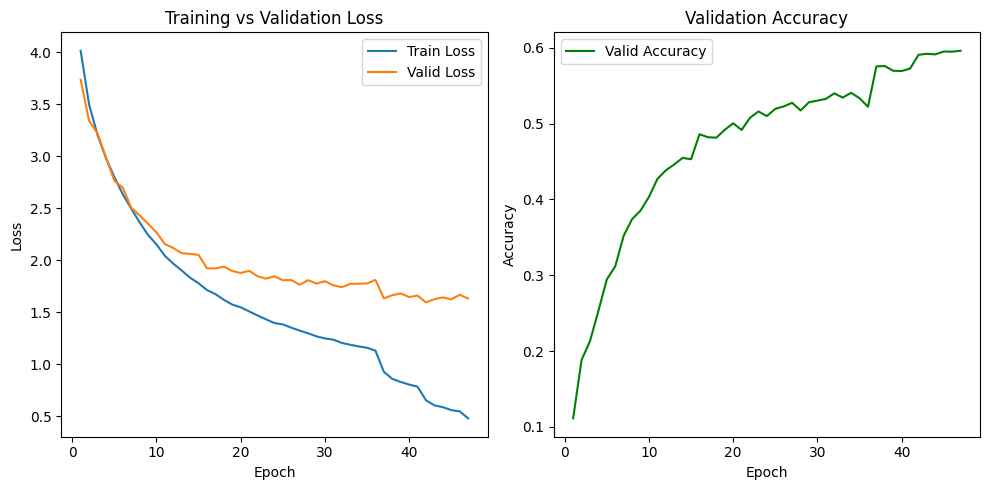

([4.013076416015625,
  3.4967808055877687,
  3.2038712993621825,
  2.9824975372314455,
  2.799518078994751,
  2.6331114185333253,
  2.4962535852432253,
  2.363669111061096,
  2.243007241439819,
  2.151771271133423,
  2.0417791639328002,
  1.9669375869750976,
  1.9007754762649536,
  1.8320553823471069,
  1.7783852422714232,
  1.7132277208328246,
  1.6741558477401732,
  1.6199616893768312,
  1.5734486709594726,
  1.547681538581848,
  1.508226626777649,
  1.4688997488975526,
  1.4320213797569274,
  1.3968038900375366,
  1.383219324016571,
  1.352302134990692,
  1.323318671321869,
  1.2982785181045533,
  1.268388939666748,
  1.248562937927246,
  1.2364695981025695,
  1.2054071347236632,
  1.1878391162872315,
  1.1715157494544983,
  1.1592848229408264,
  1.1305246282577515,
  0.9274700922012329,
  0.8598130971431732,
  0.8302826334476471,
  0.8052783826351165,
  0.7842672064304351,
  0.6538188071250916,
  0.6047913809299469,
  0.5882416699409485,
  0.5596021053791046,
  0.5476556401252747,


In [41]:
train_dataloader_model(model, train_loader, valid_loader, optim= optim, loss_fn= loss_fn)

In [42]:
model.eval()
with torch.no_grad():
    epoch_test_loss = 0
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_test_pred = model(X_test)
        c_loss = loss_fn(y_test_pred, y_test)
        epoch_test_loss += c_loss.item()
    epoch_test_loss /= len(test_loader)
    print(epoch_test_loss)

1.5002460168425444


In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 11,184,650
